In [1]:
#---------------------- Header 
from easydict import EasyDict
import os
import json
args = EasyDict()


#------ image list 
i_1 = "/mnt/hdd/eric/.tmp_ipy/00.Data/AO/0-Pusan-2023-AO/K3A_20230523045050_45040_00039701_L1G_PS/0-Pusan-2023-AO_21_K3A_20230523045050_45040_00039701_L1G_PRGB_georeferencing_32652.png"

#------ tif list 
t_1 = "/mnt/hdd/eric/.tmp_ipy/00.Data/AO/0-Pusan-2023-AO/K3A_20230523045050_45040_00039701_L1G_PS/K3A_20230523045050_45040_00039701_L1G_PRGB_georeferencing_32652.tif"


#------ gpu
args.gpu_id = 0

#------ model 
args.img_path = i_1

print( '/'.join( args.img_path.split("/")[0:-1]) )
args.infer_threshold = 0.2
source_root ='/'.join( args.img_path.split("/")[0:-1])

args.img_output = args.img_path.replace(".png" ,"_output_v3_1208.png")
args.img_output_masked = args.img_path.replace(".png" ,"_output_v3_1208_NewMasked.png")
args.csv_output = args.img_path.replace(".png","_masked_v3_1208.csv")

#------ Coordinates filtering function
args.txt_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/AO/0-Pusan-2023-AO/K3A_20230523045050_45040_00039701_L1G_PS/1RCoordinate.txt"

args.xml_path = None

#------ Map Shape 
# old mask
#args.map_path = os.path.join(source_root, "map")
#args.map_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Shape_Old"
# new mask 
args.map_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Shape_Korea_Clipped"

#------ TIF 
args.tf_path = t_1

# time 2023 05 23 04 50 50
args.year_= 2023
args.month_ = 5
args.day_ = 23
hour_ = 4
args.hour_ = hour_ + 9
args.min  = 50
args.sec =  50

#------ AIS csv 
args.data_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/AIS-CSV-NTO-AO/2차-11개/202305231300_dynamic.csv"
args.static_data_path = args.data_path.replace("_dynamic.csv","_static.csv")
args.final_merge = args.img_path.replace(".png",".csv")

# time gap
# 시각화 결과물에서 ais 좌표가 해상도가 더 높아지게 된다. 
args.time_gap_min = 1
args.time_gap_sec = False

# pixel gap 
# this is for visualization
args.pixel_gap = 200

# # latlon gap 
# # 매칭되는 박스와 ais 간의 기준 => 늘리면 R_ 데이터프레임에서 매칭 케이스가 늘어나게 된다. 
# args.latlon_gap = 0.000001

#------ Model Inference 
args.model_test = True
args.Box_Matching = True
args.png_draw_save = False


# Save EasyDict to a file
file_path = os.path.join(source_root ,"config.json" )
with open(file_path, 'w') as json_file:
    json.dump(args, json_file, indent=4)

/mnt/hdd/eric/.tmp_ipy/00.Data/AO/0-Pusan-2023-AO/K3A_20230523045050_45040_00039701_L1G_PS


In [2]:
args.img_path

'/mnt/hdd/eric/.tmp_ipy/00.Data/AO/0-Pusan-2023-AO/K3A_20230523045050_45040_00039701_L1G_PS/0-Pusan-2023-AO_21_K3A_20230523045050_45040_00039701_L1G_PRGB_georeferencing_32652.png'

In [3]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = 933120000
from adjustText import adjust_text

# Draw image 
img_path = args.img_path
img_ = Image.open(img_path)

/mnt/hdd/eric/.conda/envs/8.tmp/lib/python3.8/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (1000976050 pixels) exceeds limit of 933120000 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [4]:
img_.size

(31775, 31502)

# 1. Model Inference

In [141]:
import testModule

if args.model_test:
    result = testModule.infer_model(input_file_path=args.img_path,\
                        thres=args.infer_threshold , gpu_id = 0)

/mnt/hdd/eric/.conda/envs/8.tmp/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: /mnt/hdd/eric/.tmp_ipy/00.Checkpoint/ship_tmp/epoch_9.pth
model to device #-----------------------------# :  cuda:0
#------------------- init detection
inference_detector_by_patches GPU ! :  cuda:0


/mnt/hdd/eric/.conda/envs/8.tmp/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


In [142]:
#------------------------
# result save
import numpy as np
import os 
save_root = "/mnt/hdd/eric/.tmp_ipy/00.Data/Inference_results"
file_name = args.img_path.split("/")[-1].split(".")[0]+".npy"    

if args.model_test == False:
    result = np.load(os.path.join(save_root,file_name))
else:
    print("Result Saved")
    np.save(os.path.join(save_root,file_name), result)

Result Saved


# 2. AIS csv 

- time condition 에 맞게 filtering 

In [143]:
import pandas as pd

df = pd.read_csv(args.data_path)

In [144]:
#---- current time ----#
import datetime
year_= args.year_
month_ = args.month_ 
day_ = args.day_
hour_ = args.hour_
min  = args.min
sec =  args.sec
crit_time_str = f"{year_}-{month_}-{day_} {hour_}:{min}:{sec}"
date = pd.to_datetime(crit_time_str)

#---- time condition ----#
time_gap_min = args.time_gap_min
time_gap_sec = args.time_gap_sec

earl_time = date - datetime.timedelta(minutes=time_gap_min,seconds=time_gap_sec)
post_time = date + datetime.timedelta(minutes=time_gap_min,seconds=time_gap_sec)

print("early : ",earl_time)
print("now : ",date)
print("late : ",post_time)



early :  2023-05-23 13:49:50
now :  2023-05-23 13:50:50
late :  2023-05-23 13:51:50


In [145]:
df.columns

Index(['mmsi_', 'time', 'lon_', 'lat_', 'heading_', 'turn_', 'speed_'], dtype='object')

In [146]:
df.columns = ['mmsi_', 'time', 'long', 'lat', 'heading_', 'turn_', 'speed_']

In [147]:
df

,mmsi_,time,long,lat,heading_,turn_,speed_
0,440005700,2023-05-23 13:00:00,129.051142,35.107152,59,-128.0,0.0
1,440154850,2023-05-23 13:00:00,129.181417,35.042105,511,-128.0,6.9
2,440044920,2023-05-23 13:00:00,129.050687,35.119765,511,-128.0,0.2
3,440152080,2023-05-23 13:00:00,129.102380,35.084563,511,-128.0,10.8
4,440101370,2023-05-23 13:00:00,129.051283,35.122367,29,0.0,0.0
...,...,...,...,...,...,...,...
39331,440101100,2023-05-23 13:59:58,129.026090,35.086865,511,-128.0,0.0
39332,440152550,2023-05-23 13:59:59,129.099278,35.054523,511,-128.0,13.3
39333,440063450,2023-05-23 13:59:59,129.053487,35.121593,511,-128.0,0.0
39334,441089000,2023-05-23 13:59:59,129.256915,35.011073,30,0.0,12.1


In [148]:
#---- filtering datetime ---# 
# 
time_ = []
for i,row in df.iterrows():
    #print(row["time"])
    time_.append( pd.to_datetime( row["time"] ) )
df["datetime"] = time_

con1 = df["datetime"] < post_time 
con2 = df["datetime"] > earl_time

#--- exec ---#
time_filter_flag = True

if time_filter_flag:
    t_df = df.loc[con1 & con2] 
    df.loc[con1 & con2]
else:
    t_df = df
    t_df

In [149]:
t_df

,mmsi_,time,long,lat,heading_,turn_,speed_,datetime
33028,440110910,2023-05-23 13:49:51,129.065788,35.109163,7,-6.0,0.1,2023-05-23 13:49:51
33029,273243200,2023-05-23 13:49:51,129.066167,35.097433,0,-128.0,0.0,2023-05-23 13:49:51
33030,440108810,2023-05-23 13:49:51,129.069107,35.095458,511,-128.0,0.1,2023-05-23 13:49:51
33031,373493000,2023-05-23 13:49:51,129.065767,35.109047,82,0.0,0.0,2023-05-23 13:49:51
33032,440195340,2023-05-23 13:49:51,129.026800,35.090445,511,-128.0,0.0,2023-05-23 13:49:51
...,...,...,...,...,...,...,...,...
34427,457444000,2023-05-23 13:51:49,129.069617,35.049900,0,-128.0,0.3,2023-05-23 13:51:49
34428,440163470,2023-05-23 13:51:49,129.029008,35.086447,511,-128.0,0.0,2023-05-23 13:51:49
34429,440005700,2023-05-23 13:51:49,129.043288,35.098805,57,-128.0,0.0,2023-05-23 13:51:49
34430,440316710,2023-05-23 13:51:49,129.077300,35.087632,182,-128.0,0.2,2023-05-23 13:51:49


# 3. Coordinates filtering


In [150]:
# Coordinates filtering function ! 

if args.txt_path != None:
    txt_path = args.txt_path
    f = open(txt_path,'r')
    lines = f.readlines()
    lines

    top_left =     lines[1]
    bottom_right = lines[-1]

    min_long = float( top_left.split(":")[1].split(",")[1][0:10] )
    max_long = float( bottom_right.split(":")[1].split(",")[1][0:10] ) 

    min_lat  = float( bottom_right.split(":")[1].split(",")[0][0:10] ) 
    max_lat  = float( top_left.split(":")[1].split(",")[0][0:10] ) 

elif args.xml_path != None:
    # XML parsing
    import xml.etree.ElementTree as ET

    xml_path = args.xml_path
    tree = ET.parse(args.xml_path)
    root = tree.getroot() 


    Top_left = []
    Bottom_right = []

    for child in root:
        if child.tag =="Image":
            print(child)
            for grand_child in child:
                if grand_child.tag =="PAN":
                    for gg_child in grand_child:
                        #print(gg_child.tag)
                        if gg_child.tag == "ImagingCoordinates":
                            for ggg in gg_child:
                                
                                if ggg.tag =="ImageGeogTL":
                                    # print(ggg.tag)                         
                                    # print(ggg[0].text)
                                    # print(ggg[1].text)
                                    Top_left.append(float(ggg[0].text))
                                    Top_left.append(float(ggg[1].text))
                                elif ggg.tag == "ImageGeogBR":
                                    # print(ggg.tag)                         
                                    # print(ggg[0].text)
                                    # print(ggg[1].text)
                                    Bottom_right.append(float(ggg[0].text))
                                    Bottom_right.append(float(ggg[1].text))
    
    min_long = Top_left[1]
    max_long = Bottom_right[1]
    min_lat = Bottom_right[0]
    max_lat = Top_left[0]

# 35.032614576
# 128.632902263
# ImageGeogBR
# 34.852878881
# 128.904069499

print(min_long,max_long,min_lat,max_lat)
                                

129.081891 129.271704 35.170125 35.2482736


In [151]:
con1 = t_df["long"] > min_long
con2 = t_df["long"] < max_long

con3 = t_df["lat"] > min_lat
con4 = t_df["lat"] < max_lat + 0.0225 # debugged by eric 


#------------------------------------
location_filter_flag = True

if location_filter_flag == True:
    #q_df = df.loc[con1 & con2 & con3 & con4]
    q_df = t_df.loc[con1 & con2 & con3 & con4]
    q_df
else:
    q_df = df

In [152]:
q_df

,mmsi_,time,long,lat,heading_,turn_,speed_,datetime


In [153]:
import utm
import rasterio

#-------------------
# utm => pixels 
#------------------
utm_array =[] # long lat 
#--- csv 
# latlong --> utm
for lat,lon in zip(q_df['lat'].values,q_df['long'].values):
    #print(lat)
    # if lat < 80:
    res = utm.from_latlon(lat,lon,52,"N")
    utm_array.append(res)

# 전환한 utm_array 를 데이터프레임에 병합 
q_df['utm_array']= utm_array


pixels_=[] # utm_array 를 pixels_ 로 변경 
tf_path = args.tf_path
with rasterio.open(tf_path) as map_layer:

    for inp in utm_array:
    
        coords2pixels = map_layer.index(inp[0],inp[1]) #input lon,lat # 좌표계 
        pixels_.append(coords2pixels)

q_df['pixels'] = pixels_

#--- init index in q_df
q_df.drop_duplicates(inplace=True)
q_df.reset_index(inplace=True,drop=True)


In [154]:
# remove duplicate row 
[i[1:-1] for i in q_df['time']]
# pd.to_datetime( )

[]

In [155]:
q_df

,mmsi_,time,long,lat,heading_,turn_,speed_,datetime,utm_array,pixels


/mnt/hdd/eric/.conda/envs/8.tmp/lib/python3.8/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (1000976050 pixels) exceeds limit of 933120000 pixels, could be decompression bomb DOS attack.
  warnings.warn(


IndexError: list index out of range

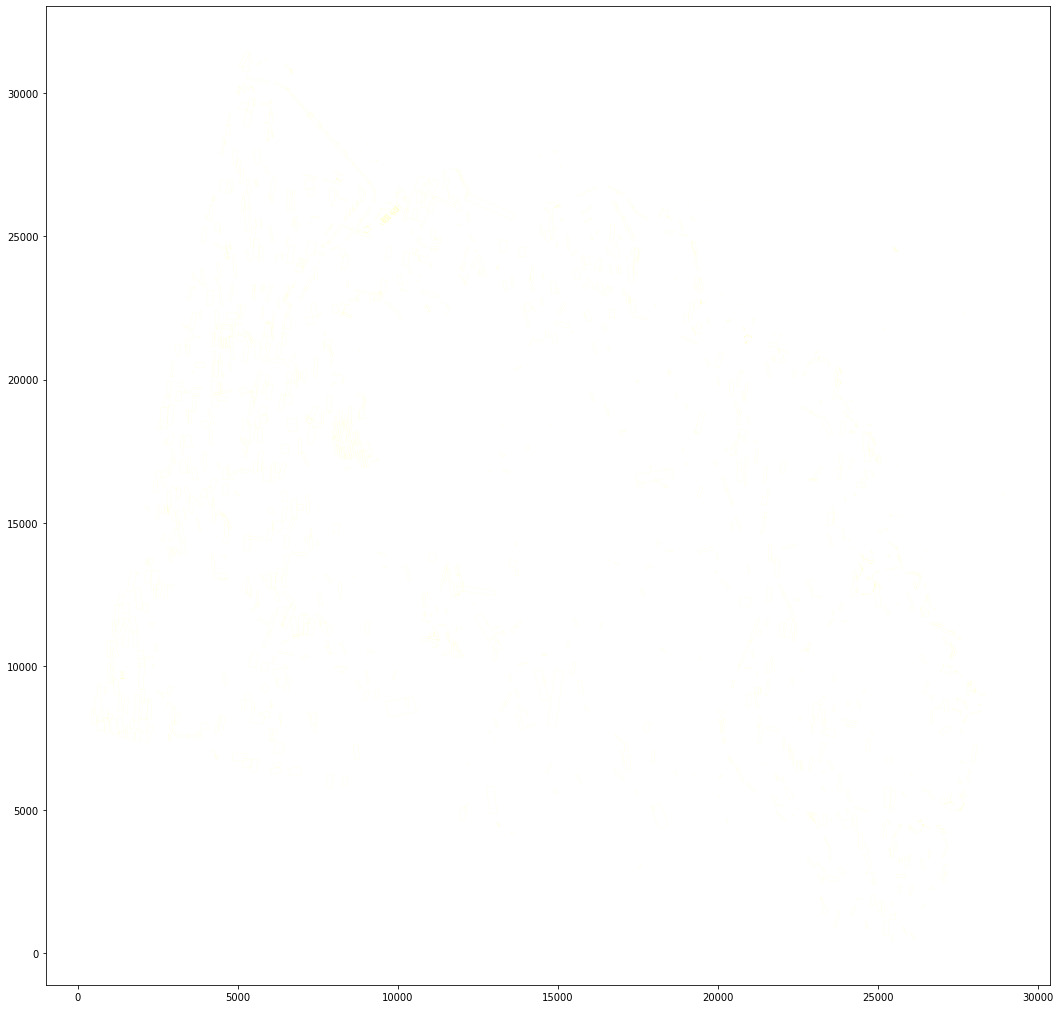

In [156]:
#------------------------------
# AIS matching with Bbox

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS = 933120000
from adjustText import adjust_text

# Draw image 
img_path = args.img_path
img_ = Image.open(img_path)
plt.figure(figsize=(18,18))
#plt.imshow(img_)
ax = plt.gca()

# Bounding Box 
# Thresholding filtering 
bboxes_ = [] 
cnt = 0
for r in result[0]:
    if r[-1] > args.infer_threshold:
        cnt+=1
        bboxes_.append(r)

#----------------------------------------------------- 
# BBox matching with AIS 

# Matched Bbox
idx_bboxes = []
x_bboxes = [] 
y_bboxes = []
width_bboxes = []
height_bboxes = []
angle_bboxes = []

# Matched AIS 
x_matched_ais = []
y_matched_ais = []
time_matched_ais = []
idxss_matched_ais = []
lat_matched_ais = []
long_matched_ais = []

# 데이터들은 q_df 써서 활용하는 것을 원칙으로 한다. 
x_ais = [i[1] for i in q_df["pixels"].values]
y_ais = [i[0] for i in q_df["pixels"].values]
lat_ais  = [i for i in q_df['lat'].values]
long_ais = [i for i in q_df['long'].values]

idx_ais = [i for i in q_df.index.values]
time_ais = [i[1:-1] for i in q_df['time']]


for bidx, box_ in enumerate( bboxes_):
    x = box_[0]
    y = box_[1]
    width =  box_[2]
    height = box_[3]
    angle_ = box_[4]
    

    # model 의 객체좌표가 center 중심인데, patches.Rectangle 은 좌하단을 기준점으로 보기 때문에. x,y 를 아래와 같이 shift 
    # roatate 할 때, 중심좌표 center 로 잡고, angle radian 변환해서 넣어주기 
    path_obj = patches.Rectangle((x-width*0.5,y-height*0.5), width, height, 
                                linewidth=0.1, edgecolor="yellow", fill=False,
                                rotation_point="center",
                                angle=angle_*180/np.pi,
                                alpha=0.35)
    
    ax.add_patch(path_obj)


    #--- find matched AIS with each box 
    cnt =0 
    for a,b,ix,t,lat_,long_ in zip(x_ais,y_ais,idx_ais,time_ais, lat_ais,long_ais):
        
        # 각 bbox 범위안에 들어오는 ais 중에서 첫번쨰 ais 만 리스트에 저장 
        if cnt ==1:
            break

        # if bbox matched with ais 
        if (x - args.pixel_gap < a < x + args.pixel_gap) & (y - args.pixel_gap < b < y + args.pixel_gap) :
            
            idx_bboxes.append(bidx)
            x_bboxes.append(x)
            y_bboxes.append(y)
            width_bboxes.append(width)
            height_bboxes.append(height)
            angle_bboxes.append(angle_)

            #-- 
            x_matched_ais.append(a)
            y_matched_ais.append(b)
            time_matched_ais.append(t)
            idxss_matched_ais.append(ix)
            lat_matched_ais.append(lat_)
            long_matched_ais.append(long_)

            cnt+=1


#-----------------
# 그렇다면 여기에서 통합된 bbox to ais csv 를 만들어버리자. 

if args.Box_Matching  == True:
    T_ = pd.DataFrame({
        "box index" : idx_bboxes,
        "bbox x coord" : x_bboxes,
        "bbox y coord" : y_bboxes,
        "bbox width" : width_bboxes,
        "bbox height" : height_bboxes,
        "bbox angle" : angle_bboxes,
        "ais x coord(pixel)" : x_matched_ais,
        "ais y coord(pixel)" : y_matched_ais, 
        "ais lat"   : lat_matched_ais,
        "ais long"  : long_matched_ais,
        "ais time" : time_matched_ais
    })

    T_.drop_duplicates(inplace=True)

    S_ = {
        'box index':[i for i in range(len(bboxes_)) if i not in idx_bboxes],
        'bbox x coord' : [],
        'bbox y coord' : [],
        'bbox width' : [],
        'bbox height' : [],
        'bbox angle' :[],
        "ais x coord(pixel)" : [0 for _ in range(len([i for i in range(len(bboxes_)) if i not in idx_bboxes]))],
        "ais y coord(pixel)" : [0 for _ in range(len([i for i in range(len(bboxes_)) if i not in idx_bboxes]))],
        "ais lat"   : [0 for _ in range(len([i for i in range(len(bboxes_)) if i not in idx_bboxes]))],
        "ais long"  : [0 for _ in range(len([i for i in range(len(bboxes_)) if i not in idx_bboxes]))],
        "ais time" : [0 for _ in range(len([i for i in range(len(bboxes_)) if i not in idx_bboxes]))],
        }

    not_include_boxes = [i for i in range(len(bboxes_)) if i not in idx_bboxes]

    for a in not_include_boxes:
        box_ = bboxes_[a]
        
        S_['bbox x coord'].append(box_[0])
        S_['bbox y coord'].append(box_[1])
        S_['bbox width'].append(box_[2])
        S_['bbox height'].append(box_[3])
        S_['bbox angle'].append(box_[4])

    S_ = pd.DataFrame(S_)

    M_ = pd.concat([T_,S_])
    del M_["box index"]
    M_.reset_index(inplace=True,drop=True)


    #----------------
    # Draw matched AIS 
    plt.scatter(x_matched_ais,y_matched_ais, alpha=0.1,color='red',marker='o',s=8)


    #--------------------------------------------
    # among the matched AIS (q_df), label and draw them 
    plt_txts = []

        
    for i,row in M_.iterrows():
        
        a = row['ais lat']
        b = row['ais long']

        x = row['ais x coord(pixel)']
        y = row['ais y coord(pixel)']


        if (x ==0) & (y ==0):
            x = row['bbox x coord']
            y = row['bbox y coord']
            name = f'bbox idx : {i}, No matched AIS point'

            #-- matched 가 되지 않은 박스들에는 레이블을 붙이지 않았음 
            #plt_txts.append( plt.text(x, y, name, fontsize =2,color='yellow') )

        else:
            name = f'bbox idx : {i}, ais coord: {a,b}'
            plt_txts.append( plt.text(x, y, name, fontsize =2,color='red') ) 


    #----------------------------------------
    # label overlap avoid 
    adjust_text(plt_txts, 
                force_points=3,
                arrowprops={'arrowstyle' : '->', 
                            'color' : 'crimson',  
                            'alpha' : 0.1}
                )
    # force_points = 3

#---------
# png save and draw
if args.png_draw_save:
    plt.savefig(args.img_output,dpi =1200 )
    plt.show()

In [ ]:
M_

,bbox x coord,bbox y coord,bbox width,bbox height,bbox angle,ais x coord(pixel),ais y coord(pixel),ais lat,ais long,ais time
0,8019.184082,20668.470703,231.906067,37.774815,0.302294,8034,20515,35.101445,129.039542,023-01-16 10:48:2
1,17841.806641,19001.281250,107.723518,20.972467,0.806699,17837,18841,35.108962,129.093330,023-01-16 10:46:0
2,12990.855469,21599.408203,158.621964,32.854607,-0.981250,12978,21492,35.097028,129.066660,023-01-16 10:46:4
3,10850.931641,16873.429688,406.804382,68.494942,0.708813,10659,16857,35.117930,129.053953,023-01-16 10:46:2
4,14663.147461,20215.708984,203.538666,40.524036,0.019692,14720,20050,35.103525,129.076220,023-01-16 10:48:2
...,...,...,...,...,...,...,...,...,...,...
7068,18161.771484,12693.241211,98.229630,15.518679,-1.394590,0,0,0.000000,0.000000,0
7069,7197.584961,7035.023438,114.928513,17.464190,-0.132863,0,0,0.000000,0.000000,0
7070,9066.768555,13871.169922,206.715073,27.697983,0.036443,0,0,0.000000,0.000000,0
7071,12286.789062,20078.960938,147.113693,34.869804,-0.795417,0,0,0.000000,0.000000,0


# Masking BBox in the land 

In [ ]:
args.map_path
os.path.exists(args.map_path)

True

------------------- Eric Edited 


<Axes: >

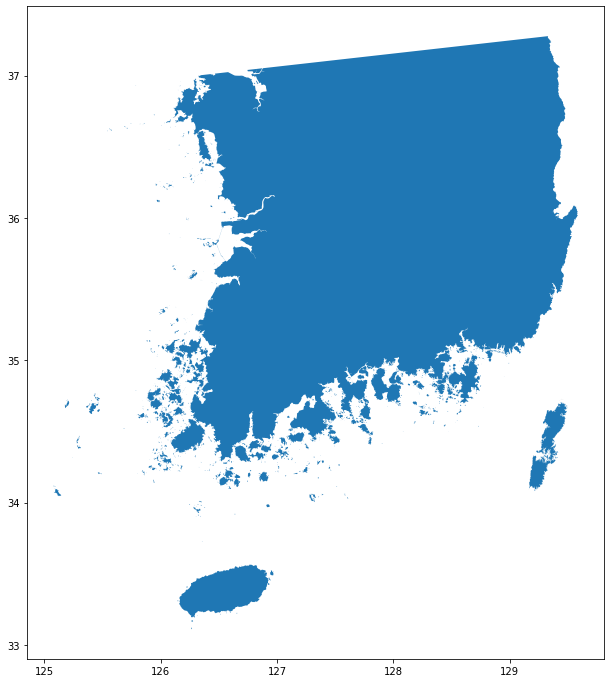

In [ ]:
# Visualize Shape File !!
import geopandas as gpd
from shapely.geometry import Point
# Masking을 위한 shape 불러오기 
gdf=gpd.GeoDataFrame.from_file(args.map_path) #shapefile 불러오기

gpd.GeoSeries(gdf['geometry']).plot(figsize=(20,12)) #shapefile 플랏


In [ ]:
import geopandas as gpd
from shapely.geometry import Point
# Masking을 위한 shape 불러오기 
gdf=gpd.GeoDataFrame.from_file(args.map_path) #shapefile 불러오기

# from pixel to utm
tmp_ =[] 
with rasterio.open(tf_path) as map_layer:
    for x,y in zip(M_['bbox x coord'].values, M_['bbox y coord'].values):
        
        x_coord,y_coord = map_layer.xy(y,x) # 여기 순서에 맞춰줘야, long,lat 좌표계가 맞음 
        tmp_.append([x_coord,y_coord])

tmp_1= []
ship_idxs = []
# from utm to latlon 
for idx,co in enumerate(tmp_):
    x,y = co[0],co[1]
    lat,lon = utm.to_latlon(x,y,52,"N")
    # print(lat,lon) # M_ 에서, 미리 설정되었던 AIS와 함께 좌표값 검증하였음

    print("progress : ", idx, " / ",len(tmp_))
    check=gdf['geometry'].contains(Point(lon,lat)) #특정 좌표 (long,lat)이 shapefile 다각형에 포함되는지 확인하기
    checkt=np.where(check == True)[0]
    
    if len(checkt) == 0:
        tmp_1.append(checkt)
        ship_idxs.append(idx)

progress :  0  /  7073
progress :  1  /  7073
progress :  2  /  7073
progress :  3  /  7073
progress :  4  /  7073
progress :  5  /  7073
progress :  6  /  7073
progress :  7  /  7073
progress :  8  /  7073
progress :  9  /  7073
progress :  10  /  7073
progress :  11  /  7073
progress :  12  /  7073
progress :  13  /  7073
progress :  14  /  7073
progress :  15  /  7073
progress :  16  /  7073
progress :  17  /  7073
progress :  18  /  7073
progress :  19  /  7073
progress :  20  /  7073
progress :  21  /  7073
progress :  22  /  7073
progress :  23  /  7073
progress :  24  /  7073
progress :  25  /  7073
progress :  26  /  7073
progress :  27  /  7073
progress :  28  /  7073
progress :  29  /  7073
progress :  30  /  7073
progress :  31  /  7073
progress :  32  /  7073
progress :  33  /  7073
progress :  34  /  7073
progress :  35  /  7073
progress :  36  /  7073
progress :  37  /  7073
progress :  38  /  7073
progress :  39  /  7073
progress :  40  /  7073
progress :  41  /  7073
pr

In [ ]:
# 마스킹하기 전, 탐색된 선박수
display(M_)

,bbox x coord,bbox y coord,bbox width,bbox height,bbox angle,ais x coord(pixel),ais y coord(pixel),ais lat,ais long,ais time
0,8019.184082,20668.470703,231.906067,37.774815,0.302294,8034,20515,35.101445,129.039542,023-01-16 10:48:2
1,17841.806641,19001.281250,107.723518,20.972467,0.806699,17837,18841,35.108962,129.093330,023-01-16 10:46:0
2,12990.855469,21599.408203,158.621964,32.854607,-0.981250,12978,21492,35.097028,129.066660,023-01-16 10:46:4
3,10850.931641,16873.429688,406.804382,68.494942,0.708813,10659,16857,35.117930,129.053953,023-01-16 10:46:2
4,14663.147461,20215.708984,203.538666,40.524036,0.019692,14720,20050,35.103525,129.076220,023-01-16 10:48:2
...,...,...,...,...,...,...,...,...,...,...
7068,18161.771484,12693.241211,98.229630,15.518679,-1.394590,0,0,0.000000,0.000000,0
7069,7197.584961,7035.023438,114.928513,17.464190,-0.132863,0,0,0.000000,0.000000,0
7070,9066.768555,13871.169922,206.715073,27.697983,0.036443,0,0,0.000000,0.000000,0
7071,12286.789062,20078.960938,147.113693,34.869804,-0.795417,0,0,0.000000,0.000000,0


In [ ]:
# visualize the result 
M_masked = M_.iloc[ship_idxs]
# sav the csv 
M_masked.to_csv(args.csv_output)
display(M_masked)

,bbox x coord,bbox y coord,bbox width,bbox height,bbox angle,ais x coord(pixel),ais y coord(pixel),ais lat,ais long,ais time
1,17841.806641,19001.281250,107.723518,20.972467,0.806699,17837,18841,35.108962,129.093330,023-01-16 10:46:0
3,10850.931641,16873.429688,406.804382,68.494942,0.708813,10659,16857,35.117930,129.053953,023-01-16 10:46:2
4,14663.147461,20215.708984,203.538666,40.524036,0.019692,14720,20050,35.103525,129.076220,023-01-16 10:48:2
5,14987.956055,20220.769531,295.849365,46.265362,0.000518,15056,20037,35.103580,129.078065,023-01-16 10:47:0
9,10637.110352,15935.937500,104.216354,19.859278,-1.232119,10567,16046,35.121587,129.053448,023-01-16 10:46:1
...,...,...,...,...,...,...,...,...,...,...
6939,6921.866211,27180.861328,23.225796,11.440117,1.331919,0,0,0.000000,0.000000,0
6962,20679.974609,23821.000000,202.953827,24.813036,-1.028675,0,0,0.000000,0.000000,0
7051,6411.806641,23491.566406,18.780706,10.154346,0.860788,0,0,0.000000,0.000000,0
7060,7740.477539,21518.394531,187.330673,32.963818,1.494409,0,0,0.000000,0.000000,0


# Masked Visualization

#-------------- 0.0010
#-------------- 0.0020
#-------------- 0.0030
#-------------- 0.0040
#-------------- 0.0049
#-------------- 0.0059
#-------------- 0.0069
#-------------- 0.0079
#-------------- 0.0089
#-------------- 0.0099
#-------------- 0.0109
#-------------- 0.0119
#-------------- 0.0128
#-------------- 0.0138
#-------------- 0.0148
#-------------- 0.0158
#-------------- 0.0168
#-------------- 0.0178
#-------------- 0.0188
#-------------- 0.0198
#-------------- 0.0208
#-------------- 0.0217
#-------------- 0.0227
#-------------- 0.0237
#-------------- 0.0247
#-------------- 0.0257
#-------------- 0.0267
#-------------- 0.0277
#-------------- 0.0287
#-------------- 0.0296
#-------------- 0.0306
#-------------- 0.0316
#-------------- 0.0326
#-------------- 0.0336
#-------------- 0.0346
#-------------- 0.0356
#-------------- 0.0366
#-------------- 0.0375
#-------------- 0.0385
#-------------- 0.0395
#-------------- 0.0405
#-------------- 0.0415
#-------------- 0.0425
#----------

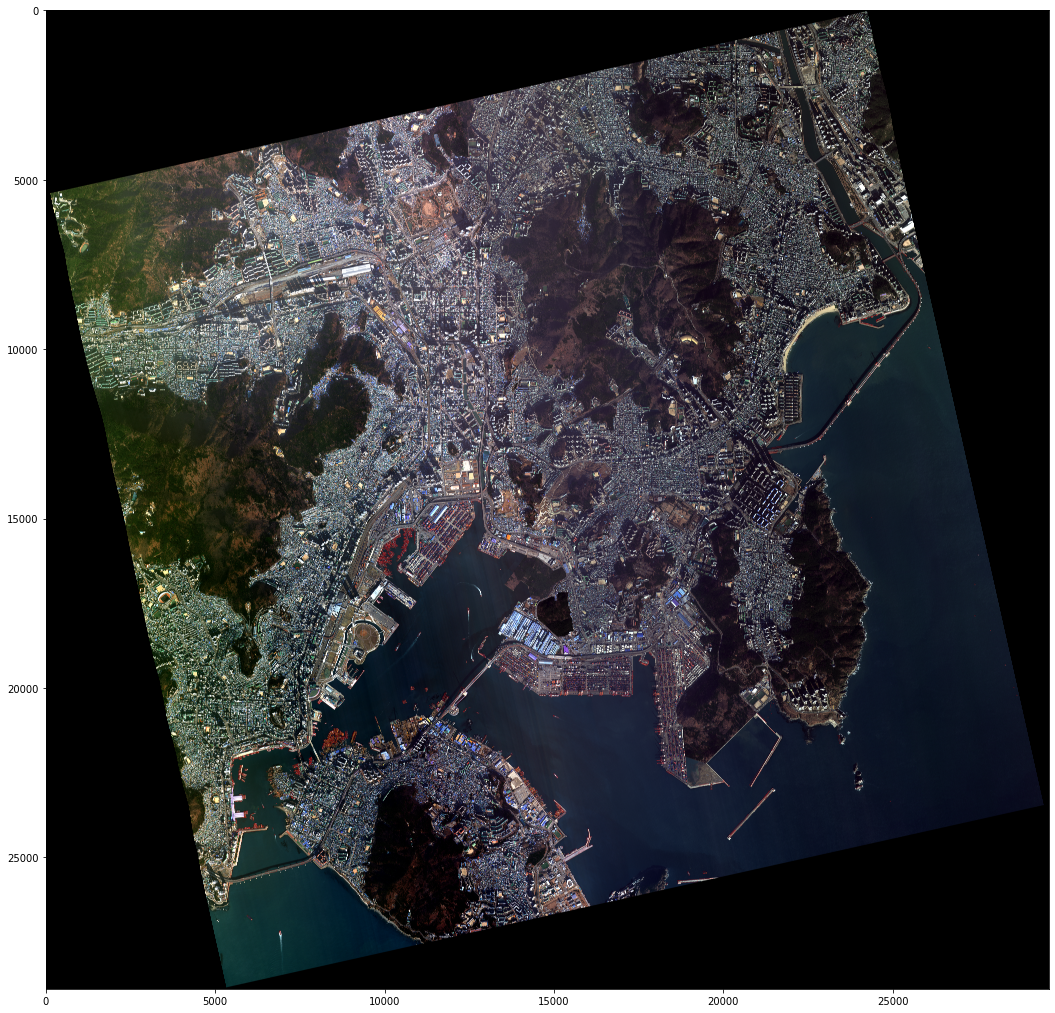

In [ ]:
# visualize the result with masking 
# original image 
img_path = args.img_path
img_ = Image.open(img_path)

plt.figure(figsize=(18,18))
plt.imshow(img_)
ax = plt.gca()

#------------------------------------
# Bbox 
bboxes_ = [] 
cnt = 0
box_cnt = 0


# M_masked
for i,row in M_masked.iterrows():
    x = row['bbox x coord']
    y = row['bbox y coord']
    width = row['bbox width']
    height = row['bbox height']
    angle_ = row['bbox angle']
    
    box_cnt+=1
    print(f"#-------------- {box_cnt / len(M_masked):.4f}")
    path_obj = patches.Rectangle((x-width*0.5,y-height*0.5), width, height, linewidth=0.1, edgecolor="red", fill=False,
                                rotation_point="center",
                                angle=angle_*180/np.pi)
    
    ax.add_patch(path_obj)
#------------------------------------


plt.savefig(args.img_output_masked,dpi =1200 )
plt.show()

In [ ]:
# # Compare Experiment No masking 

# # visualize the result 
# # original image 
# img_path = args.img_path
# img_ = Image.open(img_path)

# plt.figure(figsize=(18,18))
# plt.imshow(img_)
# ax = plt.gca()

# #------------------------------------
# # Bbox 
# bboxes_ = [] 
# cnt = 0
# box_cnt = 0


# # No_masked
# for i,row in M_.iterrows():
#     x = row['bbox x coord']
#     y = row['bbox y coord']
#     width = row['bbox width']
#     height = row['bbox height']
#     angle_ = row['bbox angle']
    
#     box_cnt+=1
#     print(f"#-------------- {box_cnt / len(M_):.4f}")
#     path_obj = patches.Rectangle((x-width*0.5,y-height*0.5), width, height, linewidth=0.1, edgecolor="red", fill=False,
#                                 rotation_point="center",
#                                 angle=angle_*180/np.pi)
    
#     ax.add_patch(path_obj)
# #------------------------------------


# plt.savefig(args.img_path.replace(".png" ,"_output_v2_1207_no_masking.png"),dpi =1200 )
# plt.show()

In [ ]:
# M_['land_included'] = tmp_1

In [ ]:
args.final_merge.replace("_PS.csv", "_PS_masking.csv")

'/mnt/hdd/eric/.tmp_ipy/00.Data/AO/0-Pusan-2023-AO/C1_20230116015105_10110_00006119_L1G_PS/0-Pusan-2023-AO_3_C1_20230116015105_10110_00006119_L1G.csv'

In [ ]:
# import os 
# M_.to_csv(os.path.join("/mnt/hdd/eric/.tmp_ipy/00.Data/tmp_","test1.csv"),index=False )

In [ ]:
# import os 
# M_.to_csv(args.final_merge,index=False )